## Modeling

In [2]:
#imports
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import datetime


#encoders
from category_encoders import TargetEncoder
import category_encoders as ce

#sklearn
import sklearn
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, RepeatedKFold

#hyperparameter tuner
import optuna


In [3]:
df = pd.read_csv('Injury_BIO_2009-2020.csv', parse_dates=['Date_Injured'])

### Preparing data for modeling

####   Remove non categorical data and further redundencies.  Create Categorical data


In [4]:
def extractMonth(dateObj):
  return str(dateObj.month)

def extractDayOfTeamYear(dateObj):
  dateofyear = float(dateObj.strftime("%j"))
  dayOfTeamYear = ((dateofyear - 62) % 365)
  return dayOfTeamYear

In [5]:
def TransformDF(df):
  """Ensures the imported df is in the correct format to begin encoding

  Args:
      df ([df]): [imported df from csv]

  Returns:
      [df]: [df with additional cols in the correct data type also dropping the Date Injured col]
  """
  df.Days_Missed = df.Days_Missed.astype(np.float64)
  df.Year = df.Year.astype(np.float64)
  df.Age = df.Age.astype(np.float64)
  df['Month_Injured'] = df.Date_Injured.apply(extractMonth)
  df['Day_Of_Team_Year'] = df.Date_Injured.apply(extractDayOfTeamYear)
  df.drop(['Date_Injured'], axis=1, inplace=True)
  return df

In [6]:
TransformDF(df)
df.head()


,Team,Year,Injury_Category,Age,Pos,Wt,Ht,Days_Missed,Month_Injured,Day_Of_Team_Year
0,RAV,2009.0,Not Specified,9082.0,GC,305.0,75.0,3.0,7,147.0
1,OTI,2009.0,Hamstring,7622.0,WR,230.0,75.0,5.0,8,152.0
2,NWE,2009.0,Not Specified,8564.0,GC,291.0,74.0,14.0,7,146.0
3,NWE,2009.0,Knee,10398.0,DE,300.0,77.0,14.0,7,146.0
4,RAI,2009.0,Not Specified,10596.0,T,325.0,79.0,11.0,7,149.0


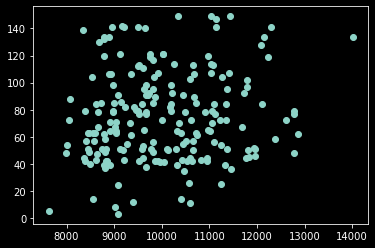

In [20]:
fig, ax = plt.subplots()
ax.scatter(df['Age'][:200], df['Days_Missed'][:200]);

#### The following two cells are for very rough inital modeling only, employs label encoding
## Do not use on final models

In [24]:
# convert string cols to category type
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()


In [165]:
#converts the category to an int value representing the category code + 1  
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    df[label] = pd.Categorical(content).codes+1



,Team,Year,Injury_Category,Age(Days),Pos,Wt,Ht,Days_Missed
0,27,2009,23,9082,11,305.0,75.0,3
1,9,2009,19,11277,18,244.0,74.0,5
2,27,2009,23,8083,44,251.0,77.0,6
3,27,2009,23,9696,45,174.0,72.0,7
4,22,2009,16,7622,45,230.0,75.0,5


## Using target encoding


In [49]:

def targetEncodeData(data):
  """Apply target encoding to data, data for quick, testing purposes only
      for more accurate encoding data must be split into test train before applying
      encoding.

  Args:
      data ([pd.DataFrame]): [dataframe to be encoded, ]

  Returns:
      [pd.DataFrame]: [df with additional encoded cols]
  """
  df = data.copy()
  # ensures cols are in type float
  df.Days_Missed = df.Days_Missed.astype(np.float64)
  df.Year = df.Year.astype(np.float64)
  df.Age = df.Age.astype(np.float64)
  # encodes the mean of data to cols
  encoder = TargetEncoder()
  df['Pos Encoded'] = encoder.fit_transform(X=df.Pos, y=df['Days_Missed'])
  enc = TargetEncoder()
  df['Team_Encoded'] = enc.fit_transform(df['Team'],df['Days_Missed'])
  enc = TargetEncoder()
  df['Month_Injured_Encoded'] = enc.fit_transform(df['Month_Injured'], df['Days_Missed'])
  enc = TargetEncoder()
  df['Injury_Category_Encoded'] = enc.fit_transform(df['Injury_Category'],df['Days_Missed'])
  return df

In [38]:
def splitData(data):
  """[create training, validation and test split for testing purposes only.  Encoding should be applied on training set before further split into valid set]

  Args:
      data ([df]): [dataframe of complete data]

  Returns:
      [type]: [a dictionary split into train test and validation sets]
  """
  train_ratio = 0.75
  validation_ratio = 0.15
  test_ratio = 0.10
  X = df.drop('Days_Missed', axis=1)
  y = df.Days_Missed

  # train is 75%
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

  # further split test into validation and test (test is 10%, val is 15%)
  X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))


  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_valid.shape, y_valid.shape)
  #create validation set
  return {
    'X_train': X_train,
    'X_test':X_test,
     'y_train': y_train,
    'y_test':y_test,
     'X_valid': X_valid,
    'y_valid':y_valid,
  }

In [ ]:
data = splitData(df)
X_train = data['X_train']
X_valid = data["X_valid"]
X_test = data['X_test']
y_train = data['y_train']
y_valid = data["y_valid"]
y_test = data['y_test']

In [16]:

# identifies target col (y)
target_col = ['Days_Missed']
# identifies cols that are in numerical form
numerical_cols = [
  'Year', 'Age', 'Wt', 'Ht', 'Day_Of_Team_Year'
  ]
cols = list(df.columns)
# identifies features that are non numerical and need to preprocesssing
features = [feat for feat in cols if feat not in numerical_cols+target_col]
features

['Team', 'Injury_Category', 'Pos', 'Month_Injured']

In [23]:
def target_enc(X_train, X_test, X_valid, features):
  """More Robust encoder for final modeling. Applies target encoding using the mean of the training data for all sets.

  Args:
      X_train ([df]): [training set]
      X_test ([df]): [testing set]
      X_valid ([df]): [validation set]
      features ([list]): [list of features that need encoding]

  Returns:
      [list of dataframes]: [dataframes with additional cols for each feature with the suffix target added, also drops original col]
  """
  targ_enc = ce.TargetEncoder(cols=features)
  targ_enc.fit(X_train[features], y_train)
  
  train_df = X_train.join(targ_enc.transform(X_train[features]).add_suffix('_target'))
  test_df = X_test.join(targ_enc.transform(X_test[features]).add_suffix('_target'))
  valid_df = X_valid.join(targ_enc.transform(X_valid[features]).add_suffix('_target'))
  
  train_df = train_df.drop(features, axis=1)
  test_df = test_df.drop(features, axis=1)
  valid_df = valid_df.drop(features, axis=1)
    
  return train_df, test_df, valid_df

In [114]:
data2 = target_enc(X_train=X_train, X_test=X_test, X_valid=X_valid, features=features)
train_df = data2[0]
test_df = data2[1]
valid_df = data2[2]

In [115]:
X_train = train_df
X_test = test_df
X_valid = valid_df

## Begin Modeling with SciKit-Learn

In [31]:

def display_scores(model):
  """Scoring function that generates Mean Absolute Error, R^2 and explained Variance for the train and validation sets

  Args:
      model (model/clf): [fitted model ready to be scored]

  Returns:
      [dict]: [returns a dictionary of scores]
  """
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_valid)
  scores = {
      "Taining MAE": mean_absolute_error(y_train, train_preds),
      "Valid MAE": mean_absolute_error(y_valid, val_preds),
      "Training R^2": r2_score(y_train, train_preds),
      "Valid R^2": r2_score(y_valid, val_preds),
      "Training Explained Variance": explained_variance_score(y_train, train_preds),
      "Valid Explained Variance": explained_variance_score(y_valid, val_preds)
    }
  return scores

In [108]:
data = splitData(df)
X_train = data['X_train']
X_valid = data["X_valid"]
X_test = data['X_test']
y_train = data['y_train']
y_valid = data["y_valid"]
y_test = data['y_test']

(3055, 9) (408, 9) (3055,) (408,) (611, 9) (611,)


In [109]:
X_train, X_test, X_valid =  target_enc(X_train, X_test, X_valid, features)

### Modeling with Random Forest Regressor from SciKit-Learn

In [110]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [57]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [111]:
display_scores(model)

{'Taining MAE': 4.2834870859636816,
 'Valid MAE': 12.632351648351648,
 'Training R^2': 0.957188221057296,
 'Valid R^2': 0.6621225859378805,
 'Training Explained Variance': 0.9571983634740817,
 'Valid Explained Variance': 0.663411607842378}

### Tuning hyperparameters 

In [43]:
rf_grid = {"n_estimators": np.arange(10, 100, 10),
          "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf": np.arange(1, 20, 2),
          "max_features": [0.5, 1, "sqrt", "auto"]}

In [58]:
rs_model2 = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=33),
                                                   param_distributions=rf_grid,
                                                   n_iter=30,
                                                   cv=cv,
                                                   verbose=True)

rs_model2.fit(X_train, y_train)

Fitting 30 folds for each of 30 candidates, totalling 900 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=33),
                   n_iter=30,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [62]:
rs_model2.best_params_

{'n_estimators': 70,
 'min_samples_split': 18,
 'min_samples_leaf': 7,
 'max_features': 'auto',
 'max_depth': None}

In [61]:
display_scores(rs_model2)

{'Taining MAE': 9.363803266180184,
 'Valid MAE': 12.741956644399556,
 'Training R^2': 0.8020382362664055,
 'Valid R^2': 0.6631381809076764,
 'Training Explained Variance': 0.8020389103993069,
 'Valid Explained Variance': 0.6644622416213873}

#### Observe feature importance for future data analysis

In [112]:
model.feature_importances_

array([0.07633387, 0.04752538, 0.03501084, 0.02062307, 0.19010739,
       0.02891911, 0.34639468, 0.02140056, 0.23368508])

In [113]:
def plot_feature_Importance(columns, importances, n=10):
  """[creates a horizontal bar graph visualizing the importance of each feature col]

  Args:
      columns ([list]): [columns in df]
      importances ([array]): [array with numerical importance of each col, 1 being most significant, 0 being insignificant]
      n (int, optional): [no of features to chart]. Defaults to 10.
  """
  df = (pd.DataFrame({"features": columns,
                      "feature_importances": importances})
        .sort_values("feature_importances", ascending=False)
        .reset_index(drop=True))
  
  #plot the df
  fig, ax = plt.subplots()
  ax.barh(df["features"][:n], df["feature_importances"][:n])
  ax.set_ylabel("Features")
  ax.set_xlabel("Feature importance")
  ax.invert_yaxis()

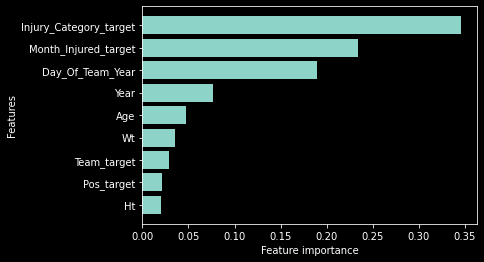

In [114]:
plot_feature_Importance(X_train.columns, model.feature_importances_)

### Modeling with ElasticNet (performed worse than randomforest)

In [54]:
# define model
elasticModel = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(elasticModel, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 19.809 (0.749)


In [55]:
elasticModel.fit(X_train, y_train)
display_scores(elasticModel)

{'Taining MAE': 19.746586685944663,
 'Valid MAE': 20.59924173084098,
 'Training R^2': 0.5490441105549329,
 'Valid R^2': 0.5019753387795843,
 'Training Explained Variance': 0.5490441105549329,
 'Valid Explained Variance': 0.5033346080703844}

#### elasic model performed significantly worse than RandomForestRegressor, hypertuning will not be performed

### Implement AdaBoost

In [59]:


clf = AdaBoostRegressor(n_estimators=100)
clf.fit(X_train, y_train)
# scores = cross_val_score(clf, X_train, y_train, cv=5)
# scores.mean()

display_scores(clf)

{'Taining MAE': 20.74683289912267,
 'Valid MAE': 21.775154893641258,
 'Training R^2': 0.5210053798291066,
 'Valid R^2': 0.4382830555685754,
 'Training Explained Variance': 0.5211219462014641,
 'Valid Explained Variance': 0.4389137614150198}

##### AdaBoost performed worse than RandomForestRegressor no hyperparameter tuning was performed

### Implement CatBoost

In [65]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, RepeatedKFold

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('Injury_BIO_2009-2020.csv', parse_dates=['Date_Injured'])
df = TransformDF(df)

In [22]:
df.head()

,Team,Year,Injury_Category,Age,Pos,Wt,Ht,Days_Missed,Month_Injured,Day_Of_Team_Year
0,RAV,2009.0,Not Specified,9082.0,GC,305.0,75.0,3.0,7,147.0
1,OTI,2009.0,Hamstring,7622.0,WR,230.0,75.0,5.0,8,152.0
2,NWE,2009.0,Not Specified,8564.0,GC,291.0,74.0,14.0,7,146.0
3,NWE,2009.0,Knee,10398.0,DE,300.0,77.0,14.0,7,146.0
4,RAI,2009.0,Not Specified,10596.0,T,325.0,79.0,11.0,7,149.0


In [23]:

RANDOM_SEED = 42

In [29]:
# split data into training and test
X = df.drop('Days_Missed', axis=1)
y = df.Days_Missed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=RANDOM_SEED)

In [30]:
#save training data for training model, used for encoding future data
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

In [25]:
def catboost_split_enc(X_train,y_train,X_test, features, rs):
    # encode nonnumerical cols listed in features using training data
    cb_enc = ce.CatBoostEncoder(cols=features)
    cb_enc.fit(X_train[features], y_train)
    # add columns for encoded data and join them to the correct col
    X_train = X_train.join(cb_enc.transform(X_train[features]).add_suffix('_cb'))
    X_test = X_test.join(cb_enc.transform(X_test[features]).add_suffix('_cb'))
    # split training into train and valid after encoding
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.18, random_state=rs)
    # drop categorical cols
    X_train.drop(features, axis=1, inplace=True)
    X_valid.drop(features, axis=1, inplace=True)
    X_test.drop(features, axis=1, inplace=True)
    # return X and y sets
    return X_train, X_valid, X_test, y_train, y_valid

In [26]:
X_train, X_valid, X_test, y_train, y_valid = catboost_split_enc(X_train,y_train, X_test, features, RANDOM_SEED)

In [121]:
catboostModel = CatBoostRegressor(random_seed=RANDOM_SEED)


In [122]:
catboostModel.fit(X_train, y_train,
eval_set=(X_valid, y_valid),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.059982
0:	learn: 37.4157659	test: 37.3371241	best: 37.3371241 (0)	total: 17.1ms	remaining: 17.1s
1:	learn: 36.2485343	test: 36.1874629	best: 36.1874629 (1)	total: 19.1ms	remaining: 9.52s
2:	learn: 35.1196337	test: 35.0737271	best: 35.0737271 (2)	total: 20.9ms	remaining: 6.93s
3:	learn: 34.1181595	test: 34.0844630	best: 34.0844630 (3)	total: 22.4ms	remaining: 5.59s
4:	learn: 33.1761256	test: 33.1926988	best: 33.1926988 (4)	total: 24.2ms	remaining: 4.82s
5:	learn: 32.2788853	test: 32.3124692	best: 32.3124692 (5)	total: 26.1ms	remaining: 4.32s
6:	learn: 31.5409814	test: 31.5901650	best: 31.5901650 (6)	total: 28.1ms	remaining: 3.98s
7:	learn: 30.6812919	test: 30.7779595	best: 30.7779595 (7)	total: 29.9ms	remaining: 3.71s
8:	learn: 29.9922784	test: 30.1161915	best: 30.1161915 (8)	total: 31.7ms	remaining: 3.49s
9:	learn: 29.3191116	test: 29.4752112	best: 29.4752112 (9)	total: 33.5ms	remaining: 3.32s
10:	learn: 28.6483206	test: 28.8251394	best: 28.8251394 (10)	total: 35

In [123]:
# no hyperparameters initial fit
display_scores(catboostModel)

{'Taining MAE': 10.501919592610724,
 'Valid MAE': 13.399901824206609,
 'Training R^2': 0.8029317409622692,
 'Valid R^2': 0.6734976979410927,
 'Training Explained Variance': 0.802931742268851,
 'Valid Explained Variance': 0.6741445823002359}

#### CatBoostRegressor performed best of models trained.  Proceed with hyperparameter training

##### use gridsearch cv to optimize hyperparameters

In [89]:
model = CatBoostRegressor(random_state=42, logging_level='Silent')
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=20, n_jobs=-1)

In [90]:
grid.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001C6659D6280>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [91]:
grid.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [92]:
display_scores(grid)

{'Taining MAE': 10.426482999454686,
 'Valid MAE': 13.515024109165024,
 'Training R^2': 0.8088634514254747,
 'Valid R^2': 0.6705061253695628,
 'Training Explained Variance': 0.808863944281316,
 'Valid Explained Variance': 0.6711118968205291}

##### no significant improvement employing gridSearch

#### Employing Optuna package to tune hyperparameters

In [95]:

# {'learning_rate': 0.018000000000000002, 'depth': 6, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1000} best performing
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 6, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_categorical('iterations', [30,100,300,1000])
    param['eval_metric'] = 'R2'
    param['od_type'] = 'Iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_valid.copy(), y_valid.copy())])
    loss = r2_score(y_valid, regressor.predict(X_valid.copy()))
    # loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [ ]:
%%time

study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}', direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=1, show_progress_bar=True)

In [97]:
study.best_params

{'learning_rate': 0.018000000000000002,
 'depth': 6,
 'l2_leaf_reg': 5.5,
 'min_child_samples': 16,
 'iterations': 1000}

In [98]:
super_model = CatBoostRegressor(
  random_seed=42,
  logging_level='Silent',
  learning_rate=0.018000000000000002, 
  depth=6, 
  l2_leaf_reg=5.5,
  min_child_samples=16,
  iterations=1000
)

In [99]:
super_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [100]:
display_scores(super_model)

{'Taining MAE': 11.077103736961925,
 'Valid MAE': 13.355171027592336,
 'Training R^2': 0.7809286380331671,
 'Valid R^2': 0.6808977677212158,
 'Training Explained Variance': 0.7809286681281253,
 'Valid Explained Variance': 0.6815504560599298}

In [101]:
def display_scoresTest_Data(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {
        "Taining MAE": mean_absolute_error(y_train, train_preds),
        'Test MAE': mean_absolute_error(y_test, test_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Test R^2": r2_score(y_test, test_preds),
        "Training Explained Variance": explained_variance_score(y_train, train_preds),
        "Test Explained Variance": explained_variance_score(y_test, test_preds)
    }
    return scores

##### Original untuned score compared to optuna score:
##### no significant improvement

In [102]:
display_scoresTest_Data(super_model)

{'Taining MAE': 11.077103736961925,
 'Test MAE': 13.000704637990045,
 'Training R^2': 0.7809286380331671,
 'Test R^2': 0.6895432891862343,
 'Training Explained Variance': 0.7809286681281253,
 'Test Explained Variance': 0.6897771598343734}

In [124]:
display_scoresTest_Data(catboostModel)

{'Taining MAE': 10.501919592610724,
 'Test MAE': 12.830619933089665,
 'Training R^2': 0.8029317409622692,
 'Test R^2': 0.6918281117624554,
 'Training Explained Variance': 0.802931742268851,
 'Test Explained Variance': 0.6919549186967575}

#### Unoptimized catboostModel is performing the best of models attempted

In [125]:
# save model
catboostModel.save_model(fname='CBModel', format='cbm')

In [126]:
# test load model
cbmodel = CatBoostRegressor()
cbmodel.load_model('cbmodel')

In [127]:
display_scores(cbmodel)

{'Taining MAE': 10.501919592610724,
 'Valid MAE': 13.399901824206609,
 'Training R^2': 0.8029317409622692,
 'Valid R^2': 0.6734976979410927,
 'Training Explained Variance': 0.802931742268851,
 'Valid Explained Variance': 0.6741445823002359}